In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '..')

from sim.LoadBalancer import LoadBalancer
from sim.Source import ArrivalSchedule, Source
from sim.Environment import Environment
import numpy as np
import random
import matplotlib.pyplot as plt
import math

### Implementing the Epsilon Greedy algorithm in our LoadBalancer structure
We use the LoadBalancer as the base class and import the epsilong greedy algorithm

In [49]:
class GreedyEpsilonLoadBalancer(LoadBalancer):
    def __init__(self, nServers, environment, model, processReward=1, cancelReward=-10, serverReward=-300, eta=0.15, nServerRange = (1,40), usePartialFit=False, periodLength =1):
        """
            model: obj with methods predict, fit, fit_partial etc.
            eta: float or callable(periodIndex: int -> float)
        """
        super().__init__(nServers, environment)
        self.model = model # a model that takes (N_t, X_t) and predicts the reward of the next time period
        self.agg = {'totalInQueue': np.mean,'requestStartWaiting':np.sum,'arrivalEvent':np.sum,'requestWaitingTime': np.mean,'requestProcessed':np.sum,'totalTimeInSystem':np.mean,'requestCancelled':np.sum}
        self.currentPeriod = 0
        self.processReward, self.cancelReward, self.serverReward = processReward, cancelReward, serverReward
        self.eta = eta
        self.nServerRange = nServerRange #the range for the bernoulli to sample from
        self.usePartialFit = usePartialFit
        self.periodLength = periodLength
        self.X = None #store the complete feature dataset here
        self.y = None #store the complete target dataset here s

    def getEta(self):
        if callable(self.eta):
            return self.eta(self.currentPeriod)
        else:
            return self.eta

    def getPreviousPeriodContext(self):
        """
        Get the context from the period that just ended (potentially add lags here from previous periods)
        """
        previousPeriodData = self.environment.getPeriodLog() #returns {key: values}
        previousPeriodContext = {key: self.agg[key](vals) for key,vals in previousPeriodData.items() if key in self.agg.keys()} #apply aggregation: go from lists to scalars
        previousPeriodContext ={key:val if not np.isnan(val) else 0 for key,val in previousPeriodContext.items()}
        previousPeriodContext ={key:previousPeriodContext[key] if key in previousPeriodContext.keys() else 0 for key in self.agg.keys()}

        self.environment.resetPeriod()
        return previousPeriodContext

    def getPreviousPeriodReward(self, context: dict):
        """
        Get the reward of the period that just ended
        """
        nProcessed = context['requestProcessed']
        nCancelled = context['requestCancelled'] if 'requestCancelled' in context.keys() else 0
        nServers = self.nServers
        reward = nProcessed * self.processReward + nCancelled * self.cancelReward + self.periodLength/60/60*nServers*self.serverReward
        print(nProcessed, nCancelled, nServers, reward)
        return reward

    def findModelOptimum(self, context):
        max = -math.inf
        maxArg = 0
        for n in range(self.nServerRange[0], self.nServerRange[1]): #implement better optimization here
            X =  np.append(np.array(list(context.values())), n)
            rewardHat = self.model.predict(X[None,:])[0]
            if rewardHat > max:
                maxArg = n
                max = rewardHat
        print("Max reward for", rewardHat, maxArg)
        return maxArg

    def getNextPeriodNumberOfServers(self, context):
        #take random action or input the context into the model and maximizy the output w.r.t N
        draw = random.random()
        eta = self.getEta()
        self.environment.logData('eta', eta)
        nServers = None
        if draw < eta or self.currentPeriod <= 1: #on first iteration the model is not fitted
            #Take random action
            self.environment.logData("greedyEpsilonActionType", 0)
            nServers = random.randint(self.nServerRange[0], self.nServerRange[1])
        else:
            self.environment.logData("greedyEpsilonActionType", 1)
            nServers = self.findModelOptimum(context) 

        return nServers
        
    def updateModel(self, context, reward):
        #update the model using the context, nServers and observed reward
        if self.currentPeriod > 0:
            newY = np.array([reward])
            self.y = np.append(self.y, newY[None,:], axis=0) if self.y is not None else newY[None,:]
            if not self.usePartialFit:
                #print(self.X.shape,self.y.shape)
                self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored
                print(self.model.score(self.X, self.y))
            else:
                raise NotImplementedError

    def updateX(self, context, nOptimal):
        newX = np.array(list(context.values()) + [nOptimal]) #+ [reward] #add the current nServers to X
        self.X = np.append(self.X, newX[None,:], axis=0) if self.X is not None else newX[None,:] #update the data 

    def onPeriodEnd(self):
        #Get the reward of the current period
        previousPeriodContext = self.getPreviousPeriodContext()
        #print(previousPeriodContext)
        previousPeriodReward = self.getPreviousPeriodReward(previousPeriodContext)
        self.environment.logData("reward", previousPeriodReward)
        self.updateModel(previousPeriodContext, previousPeriodReward)
        if self.currentPeriod>0:print(self.X.shape,self.y.shape)
        nextPeriodNServers = self.getNextPeriodNumberOfServers(previousPeriodContext)
        self._setNumberOfServers(nextPeriodNServers)
        self.updateX(previousPeriodContext, nextPeriodNServers)
        self.currentPeriod+=1
        print(self.nServers)



### Test for fixed rate

In [29]:
from BinarySearch import binaryServerSearch

opt = binaryServerSearch(5,[0,40])
print(opt)

8


In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

stopTime = 7*24*60*60
env = Environment(stopTime=stopTime)

model = LinearRegression()
model = DecisionTreeRegressor()
#sigmoid(2/(0.1*t+2)-0.5)
loadBalancer = GreedyEpsilonLoadBalancer(nServers=10, environment=env, model = model, eta=lambda t: sigmoid(2-0.05*t), nServerRange=[10,30])

requestTypes = [(0.5,1,0.1,10), (0.5,2,0.2,10)] #(prob, mu, sigma, cancelTime)
arrivalsPerSecond = 14
source = Source(arrivalsPerSecond, requestTypes, loadBalancer, env)

schedule = np.array([5]) #12 periods
periodLength = 1*60*60 #half an hour per period -> schedule repeated two times in 12 hours
arrivalSchedule = ArrivalSchedule(periodLength,arrivalSchedule=schedule, environment=env, loadBalancer=loadBalancer, source=source)
env.run(debug=False)

18109 0 10 18108.166666666668
13
17878 0 13 17876.916666666668
nan
(1, 8) (1, 1)
27


/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17999 0 27 17996.75
1.0
(2, 8) (2, 1)
15
18007 0 15 18005.75
1.0
(3, 8) (3, 1)
28
17873 0 28 17870.666666666668
1.0
(4, 8) (4, 1)
30
18081 0 30 18078.5
1.0
(5, 8) (5, 1)
Max reward for 17876.916666666668 10
10
17975 0 10 17974.166666666668
1.0
(6, 8) (6, 1)
17
17968 0 17 17966.583333333332
1.0
(7, 8) (7, 1)
19
17928 0 19 17926.416666666668
1.0
(8, 8) (8, 1)
Max reward for 17974.166666666668 10
10
17993 0 10 17992.166666666668
1.0
(9, 8) (9, 1)
29
17902 0 29 17899.583333333332
1.0
(10, 8) (10, 1)
Max reward for 18078.5 23
23


/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18039 0 23 18037.083333333332
1.0
(11, 8) (11, 1)
21


/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17930 0 21 17928.25
1.0
(12, 8) (12, 1)
27
17943 0 27 17940.75
1.0
(13, 8) (13, 1)
25


/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18028 0 25 18025.916666666668
1.0
(14, 8) (14, 1)
19
18035 0 19 18033.416666666668
1.0
(15, 8) (15, 1)
Max reward for 18025.916666666668 10
10
17967 0 10 17966.166666666668
1.0
(16, 8) (16, 1)
29
17890 0 29 17887.583333333332
1.0
(17, 8) (17, 1)
20


/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18050 0 20 18048.333333333332
1.0
(18, 8) (18, 1)
Max reward for 17974.166666666668 10
10
17958 0 10 17957.166666666668
1.0
(19, 8) (19, 1)
15
18069 0 15 18067.75
1.0
(20, 8) (20, 1)
Max reward for 17876.916666666668 10
10
17931 0 10 17930.166666666668
1.0
(21, 8) (21, 1)
19
17977 0 19 17975.416666666668
1.0
(22, 8) (22, 1)
13
18090 0 13 18088.916666666668
1.0
(23, 8) (23, 1)
13
18117 0 13 18115.916666666668
1.0
(24, 8) (24, 1)
Max reward for 18115.916666666668 10
10
18030 0 10 18029.166666666668
1.0
(25, 8) (25, 1)
27
18132 0 27 18129.75
1.0
(26, 8) (26, 1)
16
17816 0 16 17814.666666666668
1.0
(27, 8) (27, 1)
Max reward for 17870.666666666668 10
10
18051 0 10 18050.166666666668
1.0
(28, 8) (28, 1)
28
18026 0 28 18023.666666666668
1.0
(29, 8) (29, 1)
Max reward for 17996.75 10
10
18018 0 10 18017.166666666668
1.0
(30, 8) (30, 1)
Max reward for 17887.583333333332 10
10
18040 0 10 18039.166666666668
1.0
(31, 8) (31, 1)
12
17995 0 12 17994.0
1.0
(32, 8) (32, 1)
Max reward for 17966.583333

/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18038 0 23 18036.083333333332
1.0
(39, 8) (39, 1)
Max reward for 17957.166666666668 10
10
17973 0 10 17972.166666666668
1.0
(40, 8) (40, 1)
20
18088 0 20 18086.333333333332
1.0
(41, 8) (41, 1)
Max reward for 17899.583333333332 10
10
17930 0 10 17929.166666666668
1.0
(42, 8) (42, 1)
Max reward for 17887.583333333332 10
10
17999 0 10 17998.166666666668
1.0
(43, 8) (43, 1)
Max reward for 18023.666666666668 10
10
18067 0 10 18066.166666666668
1.0
(44, 8) (44, 1)
Max reward for 17994.0 10
10
18011 0 10 18010.166666666668
1.0
(45, 8) (45, 1)
Max reward for 17929.166666666668 10
10
17919 0 10 17918.166666666668
1.0
(46, 8) (46, 1)
18
18001 0 18 17999.5
1.0
(47, 8) (47, 1)
15
17963 0 15 17961.75
1.0
(48, 8) (48, 1)
Max reward for 17870.666666666668 10
10
17894 0 10 17893.166666666668
1.0
(49, 8) (49, 1)
17
17972 0 17 17970.583333333332
1.0
(50, 8) (50, 1)
23


/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18138 0 23 18136.083333333332
1.0
(51, 8) (51, 1)
Max reward for 17814.666666666668 10
10
18125 0 10 18124.166666666668
1.0
(52, 8) (52, 1)
19
18099 0 19 18097.416666666668
1.0
(53, 8) (53, 1)
30


/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17957 0 30 17954.5
1.0
(54, 8) (54, 1)
Max reward for 17926.416666666668 10
10
17914 0 10 17913.166666666668
1.0
(55, 8) (55, 1)
Max reward for 17887.583333333332 18
18
17825 0 18 17823.5
1.0
(56, 8) (56, 1)
Max reward for 18048.333333333332 10
10
17940 0 10 17939.166666666668
1.0
(57, 8) (57, 1)
Max reward for 17975.416666666668 10
10
18007 0 10 18006.166666666668
1.0
(58, 8) (58, 1)
Max reward for 17876.916666666668 10
10
18084 0 10 18083.166666666668
1.0
(59, 8) (59, 1)
Max reward for 17887.583333333332 24
24
18035 0 24 18033.0
1.0
(60, 8) (60, 1)
Max reward for 18048.333333333332 10
10
17979 0 10 17978.166666666668
1.0
(61, 8) (61, 1)
Max reward for 17887.583333333332 20
20
17943 0 20 17941.333333333332
1.0
(62, 8) (62, 1)
Max reward for 18048.333333333332 10
10
18094 0 10 18093.166666666668
1.0
(63, 8) (63, 1)
Max reward for 18083.166666666668 10
10
17769 0 10 17768.166666666668
1.0
(64, 8) (64, 1)
12
18030 0 12 18029.0
1.0
(65, 8) (65, 1)
Max reward for 18136.083333333332 19
19
1

/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17946 0 30 17943.5
1.0
(81, 8) (81, 1)
Max reward for 17996.75 10
10
18172 0 10 18171.166666666668
1.0
(82, 8) (82, 1)
Max reward for 17887.583333333332 10
10
18128 0 10 18127.166666666668
1.0
(83, 8) (83, 1)
Max reward for 17768.166666666668 10
10
17829 0 10 17828.166666666668
1.0
(84, 8) (84, 1)
Max reward for 17989.75 10
10
17938 0 10 17937.166666666668
1.0
(85, 8) (85, 1)
Max reward for 17975.416666666668 10
10
17919 0 10 17918.166666666668
1.0
(86, 8) (86, 1)
Max reward for 17975.416666666668 10
10
18171 0 10 18170.166666666668
1.0
(87, 8) (87, 1)
Max reward for 18127.166666666668 10
10
18018 0 10 18017.166666666668
1.0
(88, 8) (88, 1)
Max reward for 17870.666666666668 10
10
17952 0 10 17951.166666666668
1.0
(89, 8) (89, 1)
Max reward for 17899.583333333332 20
20
18026 0 20 18024.333333333332
1.0
(90, 8) (90, 1)
Max reward for 17870.666666666668 10
10
17977 0 10 17976.166666666668
1.0
(91, 8) (91, 1)
Max reward for 17887.583333333332 10
10
17917 0 10 17916.166666666668
1.0
(92, 8)

/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17855 0 22 17853.166666666668
1.0
(100, 8) (100, 1)
Max reward for 17853.166666666668 10
10
18108 0 10 18107.166666666668
1.0
(101, 8) (101, 1)
Max reward for 18023.666666666668 10
10
18067 0 10 18066.166666666668
1.0
(102, 8) (102, 1)
Max reward for 17899.583333333332 13
13
18000 0 13 17998.916666666668
1.0
(103, 8) (103, 1)
Max reward for 17943.5 22
22
18003 0 22 18001.166666666668
1.0
(104, 8) (104, 1)
Max reward for 17943.5 10
10
18074 0 10 18073.166666666668
1.0
(105, 8) (105, 1)
Max reward for 18148.5 20
20
18004 0 20 18002.333333333332
1.0
(106, 8) (106, 1)
Max reward for 18025.916666666668 13
13
18175 0 13 18173.916666666668
1.0
(107, 8) (107, 1)
Max reward for 17943.5 12
12
18041 0 12 18040.0
1.0
(108, 8) (108, 1)
Max reward for 17954.5 13
13
18132 0 13 18130.916666666668
1.0
(109, 8) (109, 1)
Max reward for 17954.5 13
13
17891 0 13 17889.916666666668
1.0
(110, 8) (110, 1)
Max reward for 17887.583333333332 13
13
17869 0 13 17867.916666666668
1.0
(111, 8) (111, 1)
Max reward fo

/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18004 0 20 18002.333333333332
1.0
(113, 8) (113, 1)
Max reward for 17928.25 10
10
18047 0 10 18046.166666666668
1.0
(114, 8) (114, 1)
Max reward for 18148.5 26
26
18040 0 26 18037.833333333332
1.0
(115, 8) (115, 1)
Max reward for 17922.833333333332 20
20
18024 0 20 18022.333333333332
1.0
(116, 8) (116, 1)
Max reward for 18020.583333333332 14
14
18080 0 14 18078.833333333332
1.0
(117, 8) (117, 1)
Max reward for 18115.916666666668 10
10
17914 0 10 17913.166666666668
1.0
(118, 8) (118, 1)
Max reward for 18086.333333333332 10
10
18142 0 10 18141.166666666668
1.0
(119, 8) (119, 1)
Max reward for 18097.416666666668 10
10
18068 0 10 18067.166666666668
1.0
(120, 8) (120, 1)
Max reward for 18023.666666666668 25
25


/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18061 0 25 18058.916666666668
1.0
(121, 8) (121, 1)
Max reward for 17940.75 10
10
18058 0 10 18057.166666666668
1.0
(122, 8) (122, 1)
Max reward for 17941.333333333332 10
10
17993 0 10 17992.166666666668
1.0
(123, 8) (123, 1)
Max reward for 17899.583333333332 16
16
18020 0 16 18018.666666666668
1.0
(124, 8) (124, 1)
Max reward for 18020.583333333332 20
20
18078 0 20 18076.333333333332
1.0
(125, 8) (125, 1)
Max reward for 18086.333333333332 20
20


/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17978 0 20 17976.333333333332
1.0
(126, 8) (126, 1)
Max reward for 17940.75 10
10
17920 0 10 17919.166666666668
1.0
(127, 8) (127, 1)
Max reward for 18078.5 10
10
17972 0 10 17971.166666666668
1.0
(128, 8) (128, 1)
Max reward for 17930.416666666668 10
10
18013 0 10 18012.166666666668
1.0
(129, 8) (129, 1)
Max reward for 18024.333333333332 12
12
18104 0 12 18103.0
1.0
(130, 8) (130, 1)
Max reward for 17954.5 10
10
18118 0 10 18117.166666666668
1.0
(131, 8) (131, 1)
Max reward for 18148.5 27
27
17861 0 27 17858.75
1.0
(132, 8) (132, 1)
Max reward for 18078.5 27
27


/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17972 0 27 17969.75
1.0
(133, 8) (133, 1)
Max reward for 17940.75 14
14
18044 0 14 18042.833333333332
1.0
(134, 8) (134, 1)
Max reward for 17928.25 13
13
17995 0 13 17993.916666666668
1.0
(135, 8) (135, 1)
Max reward for 18018.666666666668 10
10
17979 0 10 17978.166666666668
1.0
(136, 8) (136, 1)
Max reward for 17794.833333333332 10
10
17960 0 10 17959.166666666668
1.0
(137, 8) (137, 1)
Max reward for 17887.583333333332 12
12
17939 0 12 17938.0
1.0
(138, 8) (138, 1)
Max reward for 17887.583333333332 10
10
17947 0 10 17946.166666666668
1.0
(139, 8) (139, 1)
Max reward for 17887.583333333332 20
20
18013 0 20 18011.333333333332
1.0
(140, 8) (140, 1)
Max reward for 18078.5 29
29
18107 0 29 18104.583333333332
1.0
(141, 8) (141, 1)
Max reward for 17976.333333333332 16
16
17917 0 16 17915.666666666668
1.0
(142, 8) (142, 1)
Max reward for 17926.416666666668 10
10
17918 0 10 17917.166666666668
1.0
(143, 8) (143, 1)
Max reward for 17887.583333333332 20
20
17968 0 20 17966.333333333332
1.0
(144, 

KeyError: 'requestCancelled'

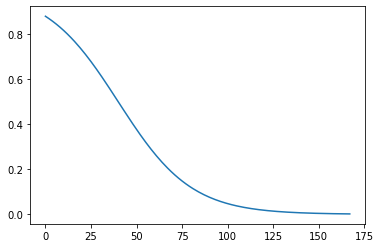

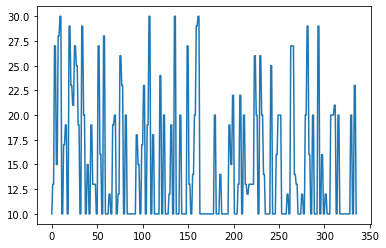

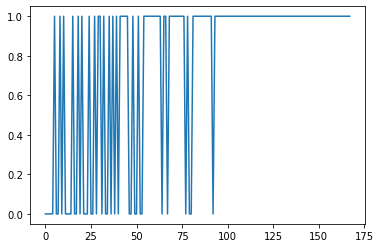

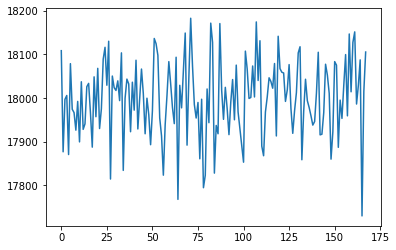

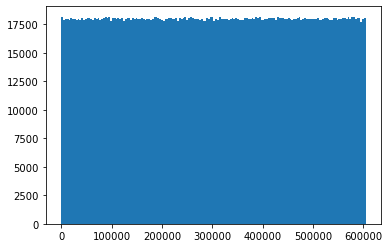

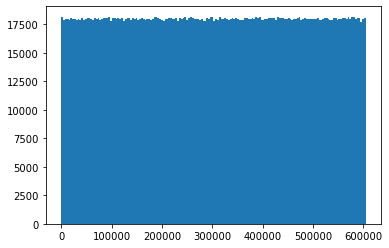

<Figure size 432x288 with 0 Axes>

In [51]:
plt.plot(env.log['eta'])
plt.figure()
plt.plot(env.log['numberOfServers'])
plt.figure()
plt.plot(env.log['greedyEpsilonActionType'])
plt.figure()
plt.plot(env.log['reward'])
plt.figure()
plt.hist(env.logTime['arrivalEvent'], bins=int(stopTime/60/60));
plt.figure()
plt.hist(env.logTime['requestProcessed'], bins=int(stopTime/60/60));
plt.figure()
plt.hist(env.logTime['requestCancelled'], bins=int(stopTime/60/60));

Text(0, 0.5, 'y')

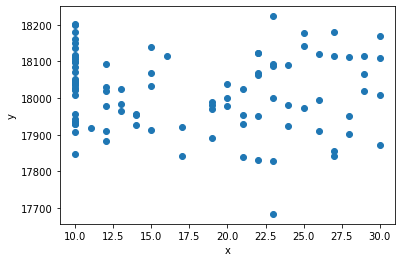

In [41]:
plt.scatter(loadBalancer.X[:-1,7],loadBalancer.y)
plt.xlabel('x')
plt.ylabel('y')

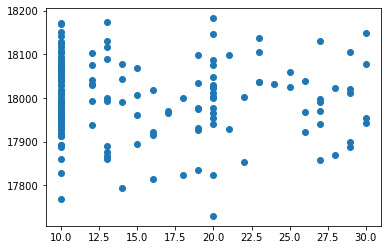

In [52]:
plt.scatter(env.log['numberOfServers'][0::2],env.log['reward'])

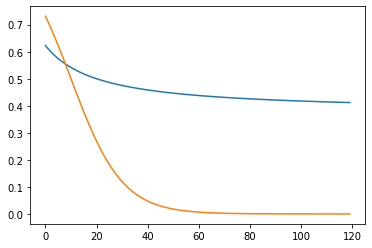

In [31]:

def sigmoid(x):
      return 1 / (1 + np.exp(-x))

x = np.arange(0,120,1)
plt.plot(x, sigmoid(2/(0.1*x+2)-0.5))
plt.plot(x, sigmoid(1-0.1*x))

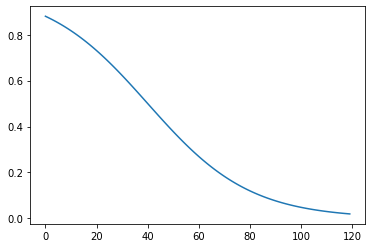

In [38]:
x = np.arange(0,120,1)
plt.plot(x, sigmoid(2-0.05*x))